In [39]:
from __future__ import print_function
#%matplotlib inline
import argparse

import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
import wandb
import os

os.environ["CUDA_VISIBLE_DEVICES"]=1

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [ ]:
wandb.init(project="fashion-mnist-gan")

In [27]:
workers = 2
batch=4
im_size = 28
nc = 1
nz = 100
ngf = 64
ndf = 64
lr = 0.0002
lr = 0.0002
ngpu = 0

In [28]:
#train_transform = 
transform = transforms.Compose([
    transforms.Scale(64),
    transforms.ToTensor(),
])
train_set = dset.FashionMNIST('./data', train=True, transform=transform, target_transform=None, download=True)
test_set = dset.FashionMNIST('./data', train=False, transform=transform, target_transform=None, download=True)

In [29]:
print(train_set)

Dataset FashionMNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Scale(size=64, interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                         )
    Target Transforms (if any): None


In [30]:
train_loader = data.DataLoader(train_set, batch_size=batch, shuffle=True,num_workers=workers)
test_loader = data.DataLoader(test_set, batch_size=batch, shuffle=True,num_workers=workers)

In [31]:

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

In [32]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [33]:
netG = Generator(ngpu)
netD = Discriminator(ngpu)
wandb.watch(netG)
wandb.watch(netD)


In [34]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, nz, 1, 1)
real_label = 1
fake_label = 0
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

In [36]:
device = torch.device('cpu')
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0
num_epochs=5

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/5][0/15000]	Loss_D: 0.5332	Loss_G: 5.5197	D(x): 0.8314	D(G(z)): 0.2915 / 0.0042
[0/5][50/15000]	Loss_D: 0.0236	Loss_G: 11.3495	D(x): 0.9777	D(G(z)): 0.0002 / 0.0000
[0/5][100/15000]	Loss_D: 0.0001	Loss_G: 10.4113	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[0/5][150/15000]	Loss_D: 0.2713	Loss_G: 13.5018	D(x): 0.9946	D(G(z)): 0.2304 / 0.0000
[0/5][200/15000]	Loss_D: 0.0482	Loss_G: 9.7880	D(x): 0.9996	D(G(z)): 0.0461 / 0.0001
[0/5][250/15000]	Loss_D: 0.0210	Loss_G: 8.1661	D(x): 0.9798	D(G(z)): 0.0004 / 0.0004
[0/5][300/15000]	Loss_D: 0.4193	Loss_G: 2.8705	D(x): 0.7869	D(G(z)): 0.1060 / 0.0757
[0/5][350/15000]	Loss_D: 0.4157	Loss_G: 3.5655	D(x): 0.8112	D(G(z)): 0.1572 / 0.0501
[0/5][400/15000]	Loss_D: 0.4722	Loss_G: 3.2999	D(x): 0.9008	D(G(z)): 0.2707 / 0.0930
[0/5][450/15000]	Loss_D: 0.3884	Loss_G: 3.9007	D(x): 0.9641	D(G(z)): 0.2821 / 0.0256
[0/5][500/15000]	Loss_D: 0.3016	Loss_G: 2.9878	D(x): 0.8475	D(G(z)): 0.0912 / 0.0533
[0/5][550/15000]	Loss_D: 1.1411	Loss_G:

[0/5][4800/15000]	Loss_D: 0.1216	Loss_G: 6.5412	D(x): 0.9132	D(G(z)): 0.0182 / 0.0092
[0/5][4850/15000]	Loss_D: 0.0168	Loss_G: 4.3842	D(x): 0.9992	D(G(z)): 0.0158 / 0.0208
[0/5][4900/15000]	Loss_D: 0.8006	Loss_G: 0.7144	D(x): 0.5112	D(G(z)): 0.0250 / 0.5030
[0/5][4950/15000]	Loss_D: 0.7907	Loss_G: 6.7680	D(x): 0.5912	D(G(z)): 0.0003 / 0.0022
[0/5][5000/15000]	Loss_D: 0.0321	Loss_G: 4.2775	D(x): 0.9927	D(G(z)): 0.0244 / 0.0163
[0/5][5050/15000]	Loss_D: 0.1242	Loss_G: 4.9255	D(x): 0.9910	D(G(z)): 0.1003 / 0.0115
[0/5][5100/15000]	Loss_D: 0.0056	Loss_G: 6.0634	D(x): 0.9989	D(G(z)): 0.0045 / 0.0029
[0/5][5150/15000]	Loss_D: 0.5753	Loss_G: 9.6544	D(x): 0.9993	D(G(z)): 0.4015 / 0.0001
[0/5][5200/15000]	Loss_D: 0.3276	Loss_G: 6.2327	D(x): 0.9994	D(G(z)): 0.2405 / 0.0022
[0/5][5250/15000]	Loss_D: 0.0571	Loss_G: 4.0866	D(x): 0.9594	D(G(z)): 0.0150 / 0.0202
[0/5][5300/15000]	Loss_D: 0.5414	Loss_G: 2.9027	D(x): 0.6555	D(G(z)): 0.0433 / 0.1096
[0/5][5350/15000]	Loss_D: 0.0261	Loss_G: 7.7177	D(x): 

[0/5][9600/15000]	Loss_D: 0.1365	Loss_G: 10.0485	D(x): 0.8798	D(G(z)): 0.0001 / 0.0001
[0/5][9650/15000]	Loss_D: 0.1268	Loss_G: 4.8202	D(x): 0.9982	D(G(z)): 0.1019 / 0.0140
[0/5][9700/15000]	Loss_D: 0.0147	Loss_G: 2.9295	D(x): 0.9997	D(G(z)): 0.0142 / 0.1219
[0/5][9750/15000]	Loss_D: 0.0018	Loss_G: 7.7904	D(x): 0.9988	D(G(z)): 0.0006 / 0.0006
[0/5][9800/15000]	Loss_D: 0.3702	Loss_G: 5.3048	D(x): 0.7873	D(G(z)): 0.0042 / 0.0080
[0/5][9850/15000]	Loss_D: 0.0045	Loss_G: 7.1336	D(x): 0.9967	D(G(z)): 0.0011 / 0.0014
[0/5][9900/15000]	Loss_D: 0.4741	Loss_G: 8.0587	D(x): 0.6319	D(G(z)): 0.0000 / 0.0012
[0/5][9950/15000]	Loss_D: 0.0080	Loss_G: 8.8409	D(x): 0.9925	D(G(z)): 0.0004 / 0.0003
[0/5][10000/15000]	Loss_D: 0.0125	Loss_G: 4.9969	D(x): 0.9955	D(G(z)): 0.0080 / 0.0071
[0/5][10050/15000]	Loss_D: 0.0037	Loss_G: 11.0571	D(x): 0.9963	D(G(z)): 0.0000 / 0.0000
[0/5][10100/15000]	Loss_D: 0.0034	Loss_G: 9.6274	D(x): 0.9970	D(G(z)): 0.0004 / 0.0004
[0/5][10150/15000]	Loss_D: 0.0517	Loss_G: 3.8176	

[0/5][14350/15000]	Loss_D: 0.0714	Loss_G: 5.5320	D(x): 0.9980	D(G(z)): 0.0653 / 0.0050
[0/5][14400/15000]	Loss_D: 0.0015	Loss_G: 8.7854	D(x): 0.9987	D(G(z)): 0.0002 / 0.0003
[0/5][14450/15000]	Loss_D: 0.0539	Loss_G: 4.7020	D(x): 0.9991	D(G(z)): 0.0508 / 0.0119
[0/5][14500/15000]	Loss_D: 0.0002	Loss_G: 8.8556	D(x): 1.0000	D(G(z)): 0.0002 / 0.0002
[0/5][14550/15000]	Loss_D: 0.0120	Loss_G: 5.4714	D(x): 1.0000	D(G(z)): 0.0119 / 0.0059
[0/5][14600/15000]	Loss_D: 0.4987	Loss_G: 4.1404	D(x): 0.7577	D(G(z)): 0.0243 / 0.0195
[0/5][14650/15000]	Loss_D: 0.0049	Loss_G: 8.2816	D(x): 0.9978	D(G(z)): 0.0027 / 0.0016
[0/5][14700/15000]	Loss_D: 0.0282	Loss_G: 10.7621	D(x): 0.9731	D(G(z)): 0.0003 / 0.0001
[0/5][14750/15000]	Loss_D: 0.0868	Loss_G: 4.7484	D(x): 0.9251	D(G(z)): 0.0056 / 0.0112
[0/5][14800/15000]	Loss_D: 0.6371	Loss_G: 6.3339	D(x): 0.6021	D(G(z)): 0.0001 / 0.0027
[0/5][14850/15000]	Loss_D: 0.2680	Loss_G: 6.0632	D(x): 0.8243	D(G(z)): 0.0028 / 0.0058
[0/5][14900/15000]	Loss_D: 0.3864	Loss_G: 

KeyboardInterrupt: 

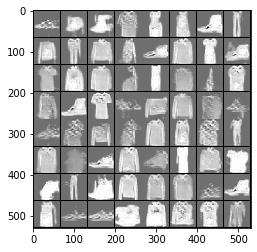

In [44]:
import matplotlib.pyplot as plt
for item in img_list:
    im = transforms.ToPILImage()(item)
    plt.imshow(im)